# Identifying and Explaining Crime Hotspots in London

In [4]:
# Data reading and processing

In [7]:
# load all the packages first
import os
import pandas as pd
import geopandas as gpd
import requests
import zipfile
from pathlib import Path
import numpy as np
from sklearn.preprocessing import PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.gridspec as gridspec
from statsmodels.stats.stattools import durbin_watson
from sklearn.decomposition import PCA
from kneed import KneeLocator
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



In [2]:
# read in LSOA crime data
df_recent = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/MPS%20LSOA%20Level%20Crime%20(most%20recent%2024%20months).csv")
df_historical = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/MPS%20LSOA%20Level%20Crime%20(Historical).csv")

# read in 2021 census data
df_residents = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/population.csv")
df_qualification = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/highest_level_of_qualification.csv")
df_language = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/household_language.csv")
df_economic_active = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/economic_active_status.csv")
df_car = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/car_or_van_availability.csv")
df_bedrooms = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/occupancy_rating_for_bedrooms.csv")
df_health = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/general_health.csv")
df_disability = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/disability.csv")

# read in PTAI data
df_PTAI = pd.read_csv("https://raw.githubusercontent.com/Weining5619/DSSS/refs/heads/main/data/LSOA2011_AvPTAI2015.csv")

In [8]:
# download geo boundaries

# first download the zip file to the data folder, and then unzip it to data/LSOA_Boundaries_London/
# create a "data" folder（if do not exist）
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)

# download the zip file (if do not exist)
zip_filename = "LSOA_Boundaries_London.zip"
zip_path = os.path.join(data_dir, zip_filename)

if not os.path.exists(zip_path):
    url = "https://github.com/Weining5619/DSSS/raw/main/data/LSOA_Boundaries_London.zip"
    response = requests.get(url)
    if response.status_code == 200:
        with open(zip_path, "wb") as f:
            f.write(response.content)
    else:
        raise Exception(f"Download failed. Status code: {response.status_code}")

# unzip the file (if do not exist)
extract_dir = os.path.join(data_dir, "LSOA_Boundaries_London")
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_dir)


In [9]:
# read in the shapefiles
# (It is a bit complicated here because the LSOA boundaries I found are stored by borough)

shp_folder = "data/LSOA_Boundaries_London"

# find all .shp files
shp_files = [
    shp for shp in Path(shp_folder).rglob("*.shp")
    if not shp.name.startswith("._") # exclude cache files generated by macOS when unzipping (e.g. ._xxx.shp), as they will cause errors.
]

# read them all into a gdf
gdf_list = [gpd.read_file(shp) for shp in shp_files]
gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)

In [10]:
# conver crime data to long table
# first replace spaces in column names with underscores

def clean_columns(df):
    '''
    Unify the format of column names
    '''
    df.columns = df.columns.str.strip().str.replace(" ", "_")
    if "geography_code" in df.columns:
        df.rename(columns={"geography_code": "LSOA_Code"}, inplace=True)
    return df

df_recent = clean_columns(df_recent)

# find all the columns of months
date_cols_rec = [col for col in df_recent.columns if col.isdigit() and col < "202501"]

# conver to long table
df_recent_long = df_recent.melt(
    id_vars=["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"],
    value_vars=date_cols_rec,
    var_name="YearMonth",
    value_name="CrimeCount"
)

# make it consistent with the number of LSOAs in gdf
df_recent_new = gdf[["LSOA11CD"]].copy()
df_recent_new = df_recent_new.rename(columns={"LSOA11CD": "LSOA_Code"})
df_recent_new = df_recent_new.merge(df_recent_long, on="LSOA_Code", how="left")

In [11]:
# do similar processing on historical crime data
df_historical = clean_columns(df_historical)

# drop columns before the year 2021
date_cols_his = [col for col in df_historical.columns if col.isdigit() and col >= "202101"]
cols_to_keep = ["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"] + date_cols_his
df_historical = df_historical[cols_to_keep]

# conver to long table
df_historical_long = df_historical.melt(
    id_vars=["LSOA_Code", "LSOA_Name", "Borough", "Major_Category", "Minor_Category"],
    value_vars=date_cols_his,
    var_name="YearMonth",
    value_name="CrimeCount"
)

# make it consistent with the number of LSOAs in gdf
df_historical_new = gdf[["LSOA11CD"]].copy()
df_historical_new = df_historical_new.rename(columns={"LSOA11CD": "LSOA_Code"})
df_historical_new = df_historical_new.merge(df_historical_long, on="LSOA_Code", how="left")

In [13]:
# combine crime data of recent 24 months and historical
df_crime = pd.concat([df_historical_new, df_recent_new], ignore_index=True)



In [16]:
# count the number of crimes by year
df_crime["Year"] = df_crime["YearMonth"].str[:4] # extract the year
annual_crime_count = df_crime.groupby(["LSOA_Code","Year", "Major_Category"])["CrimeCount"].sum().reset_index()


In [18]:
# handle column names 
df_residents = clean_columns(df_residents)
df_residents = df_residents.rename(columns={"LSOA_code": "LSOA_Code"})
df_population = df_residents[["LSOA_Code", "All_usual_residents"]].copy()

# merge population and crime count
crime_rate = annual_crime_count.merge(df_population, on="LSOA_Code", how="left")

# calculate the number of cases per 1000 population as the crime rate
crime_rate["Crime_Rate_per_1000"] = crime_rate["CrimeCount"] / crime_rate["All_usual_residents"] * 1000

df_all = crime_rate[["LSOA_Code", "Year", "Major_Category", "Crime_Rate_per_1000"]]

在本研究中，数据涉及的 LSOA 数量存在一定差异。根据 2011 年的官方边界数据，伦敦共划分为 4,835 个 LSOA。然而，2021 年人口普查（Census 2021）中仅对其中 4,659 个 LSOA 提供了详细的社会经济数据，这主要是因为部分区域（如公园、工业区、机场等）属于非住宅区域，无常住人口，因此未被纳入统计。同样地，在犯罪数据中，也可能存在部分 LSOA 因无报案记录而缺失。

鉴于本研究关注的是犯罪率与社会经济变量之间的关系，将这些未参与统计或未发生犯罪的区域视为“犯罪为 0” 是合理且常见的处理方式。这样的简化不会影响对整体模式的分析，反而有助于保持数据的一致性与稳定性。

In [19]:
# process census data
df_qualification = clean_columns(df_qualification)
df_language = clean_columns(df_language)
df_economic_active = clean_columns(df_economic_active)
df_car = clean_columns(df_car)
df_bedrooms = clean_columns(df_bedrooms)
df_health = clean_columns(df_health)
df_disability = clean_columns(df_disability)
df_PTAI = clean_columns(df_PTAI)
df_PTAI = df_PTAI.rename(columns={"LSOA2011": "LSOA_Code"})

# drop all "date", "geography" columns to prevent duplicate columns which causes errors when merge
df_language.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_economic_active.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_car.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_bedrooms.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_health.drop(columns=["date", "geography"], inplace=True, errors="ignore")
df_disability.drop(columns=["date", "geography"], inplace=True, errors="ignore")

# merge all census as a combined dataframe
df_var = df_qualification.merge(df_language, on="LSOA_Code", how="left")
df_var = df_var.merge(df_economic_active, on="LSOA_Code", how="left")
df_var = df_var.merge(df_car, on="LSOA_Code", how="left")
df_var = df_var.merge(df_bedrooms, on="LSOA_Code", how="left")
df_var = df_var.merge(df_health, on="LSOA_Code", how="left")
df_var = df_var.merge(df_disability, on="LSOA_Code", how="left")
df_var = df_var.merge(df_PTAI, on="LSOA_Code", how="left")

# Keep only the data of London
London_LOSAs = gdf["LSOA11CD"].tolist()
df_var = df_var[df_var["LSOA_Code"].isin(London_LOSAs)].copy()

In [20]:
# process all the variables
# Low_Education_Rate = (No qualifications + Level1 + Level2) / All above 16
df_var["Low_Education_Rate"] = (
    df_var["Highest_level_of_qualification:_No_qualifications"] +
    df_var["Highest_level_of_qualification:_Level_1_and_entry_level_qualifications"] +
    df_var["Highest_level_of_qualification:_Level_2_qualifications"]
) / df_var["Highest_level_of_qualification:_Total:_All_usual_residents_aged_16_years_and_over"]

# Non_English_Household_Rate = (no English + no adults but children) / All
df_var["Non_English_Household_Rate"] = (
    df_var["Household_language_(English_and_Welsh):_No_people_in_household_have_English_in_England,_or_English_or_Welsh_in_Wales_as_a_main_language"] +
    df_var["Household_language_(English_and_Welsh):_No_adults_in_household,_but_at_least_one_person_aged_3_to_15_years,_has_English_in_England_or_English_or_Welsh_in_Wales_as_a_main_language"]
) / df_var["Household_language_(English_and_Welsh):_Total:_All_households"]

# Unemployed_Rate = unemployed (students + nonstudents) / All economically active
#   According to the standard definition of unemployment rate used by ONS and ILO, 
#   economically inactive people, such as students, retirees, and those taking care of families, are not included in the denominator.
df_var["Unemployed_Rate"] = (
    df_var["Economic_activity_status:_Economically_active_(excluding_full-time_students):_Unemployed"] +
    df_var["Economic_activity_status:_Economically_active_and_a_full-time_student:_Unemployed"]
) / (df_var["Economic_activity_status:_Total:_All_usual_residents_aged_16_years_and_over"]-
    df_var["Economic_activity_status:_Economically_inactive"])

# No_Car_Rate = No car / All
df_var["No_Car_Rate"] = df_var["Number_of_cars_or_vans:_No_cars_or_vans_in_household"] / df_var["Number_of_cars_or_vans:_Total:_All_households"]

# Overcrowding_Rate = lack of bedrooms / All
df_var["Overcrowding_Rate"] = (
    df_var["Occupancy_rating_for_bedrooms:_Occupancy_rating_of_bedrooms:_-1"] +
    df_var["Occupancy_rating_for_bedrooms:_Occupancy_rating_of_bedrooms:_-2_or_less"]
) / df_var["Occupancy_rating_for_bedrooms:_Total:_All_households"]

# Poor_Health_Rate = bad health + very bad / All
df_var["Poor_Health_Rate"] = (
    df_var["General_health:_Bad_health"] +
    df_var["General_health:_Very_bad_health"]
) / df_var["General_health:_Total:_All_usual_residents"]

# Disability_Rate = disabled / All
df_var["Disabled_Rate"] = df_var["Disability:_Disabled_under_the_Equality_Act"] / df_var["Disability:_Total:_All_usual_residents"]

# Long_Term_Sick_Rate = long-term sick / All
df_var["Long_Term_Sick_Rate"] = df_var["Disability:_Not_disabled_under_the_Equality_Act:_Has_long_term_physical_or_mental_health_condition_but_day-to-day_activities_are_not_limited"] / df_var["Disability:_Total:_All_usual_residents"]

# Public_Transport_Accessibility_Index
df_var["Public_Transport_Accessibility"] = df_var["AvPTAI2015"]

# merge the data obtained above into crime rate
col_vars = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "Public_Transport_Accessibility"
]
df_var_only = df_var[["LSOA_Code"] + col_vars]
df_all = df_all.merge(df_var_only, on=["LSOA_Code"], how="left")

犯罪行为的产生往往与身心脆弱状态密切相关，而“非残疾但有长期疾病”正是这个模糊边界中最容易被忽视的一类人群。很多研究表明，慢性病或心理问题未必限制日常活动，但确实降低了社会适应能力，在高压环境下可能关联犯罪行为（如暴力、防卫性犯罪、自我保护性偷窃等）。所以我引入了“长期病患”这个变量，来更全面地反映社会经济变量对犯罪行为的影响。general health 是来源于住户自己的评价，较为主观；而 disability 是基于残疾人法案的定义，较为客观。两者结合使用，可以更全面地反映社会经济变量对犯罪行为的影响。


In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18612 entries, 0 to 18611
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   LSOA_Code                       18612 non-null  object 
 1   Year                            18612 non-null  object 
 2   Crime_Rate_per_1000             18612 non-null  float64
 3   Low_Education_Rate              18612 non-null  float64
 4   Non_English_Household_Rate      18612 non-null  float64
 5   Unemployed_Rate                 18612 non-null  float64
 6   No_Car_Rate                     18612 non-null  float64
 7   Overcrowding_Rate               18612 non-null  float64
 8   Poor_Health_Rate                18612 non-null  float64
 9   Disabled_Rate                   18612 non-null  float64
 10  Long_Term_Sick_Rate             18612 non-null  float64
 11  Public_Transport_Accessibility  18612 non-null  float64
dtypes: float64(10), object(2)
memory

## 4. Methodology

[[ go back to the top ]](#Table-of-contents)


首先看一下数据分布，经过前期的EDA发现Crime_Rate和Public_Transport_Accessibility存在严重的长尾和极端值，Unemployed_Rate也比较严重，但是又不能直接将其删除，因为它们可能是重要的特征。所以我们对上述几个变量做了对数变换。由于Crime_Rate log 后还是比较严重的右偏，所以做了Yeo-Johnson ，一种 对数和幂函数的泛化变换，让偏态数据变得更像正态分布。尽管clustering和regression都不强制需要对数据进行正态化，但是对数变换可以让数据分布更均匀，避免极端值的影响。变换后的分布图如图2，都在可以接受的范围内。

本研究首先通过 KMeans 聚类对 LSOA 进行了类型划分，发现不同位置的区域在多个年份中呈现出不同的犯罪率水平，且这些差异在空间上具有显著的分布特征。这说明，尽管 Census 数据是静态的，但犯罪率作为动态变量，可能同时受到地区固定效应（如社会经济结构、交通可达性等）与时间变化因素的共同影响。因此，为进一步捕捉跨时间与空间维度的犯罪变化机制，本研究采用 Panel Regression 对犯罪率进行建模分析。

In [45]:
# log transformation
epsilon = 1e-6

df_all["Crime_Rate_log"] = np.log(df_all["Crime_Rate_per_1000"] + epsilon)
df_all["PTA_log"] = np.log(df_all["Public_Transport_Accessibility"] + epsilon)
df_all["Unemployed_Rate_log"] = np.log(df_all["Unemployed_Rate"] + epsilon)

# Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
df_all['Crime_Rate_yj'] = pt.fit_transform(df_all[['Crime_Rate_per_1000']])


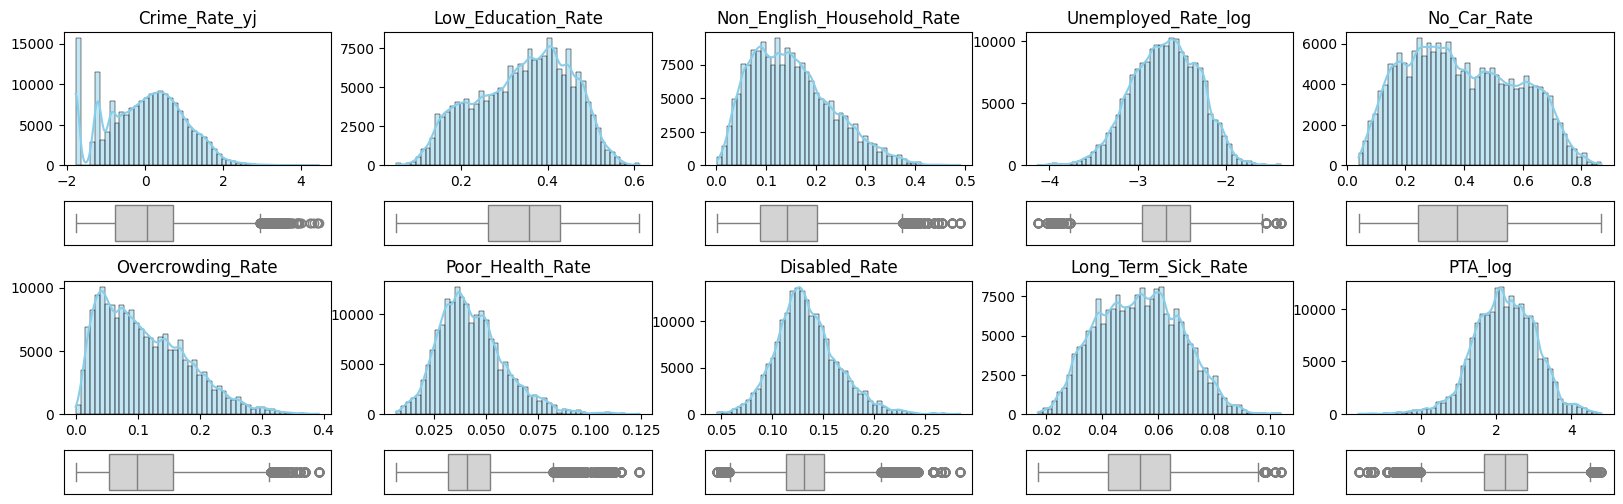

In [24]:
# plot the distribution of all variables
cols_to_plot = [
    "Crime_Rate_yj",
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(4, 5, height_ratios=[3, 1, 3, 1], hspace=0.4)

for i, col in enumerate(cols_to_plot):
    col_index = i % 5
    row_base = (i // 5) * 2  # each group occupies two lines

    # Up: Histogram (height*3)
    ax_hist = fig.add_subplot(gs[row_base, col_index])
    sns.histplot(df_all[col], kde=True, bins=50, color='skyblue', ax=ax_hist)
    ax_hist.set_title(col, fontsize=12)
    ax_hist.set_xlabel("")
    ax_hist.set_ylabel("")
    ax_hist.tick_params(axis='x', labelsize=10)
    ax_hist.tick_params(axis='y', labelsize=10)

    # Down: Box plot (height*1)
    ax_box = fig.add_subplot(gs[row_base + 1, col_index])
    sns.boxplot(x=df_all[col], color='lightgray', ax=ax_box)
    ax_box.set_xlabel("")
    ax_box.set_xticks([]) # remobe x, y axis ticks
    ax_box.set_yticks([])

plt.show()

首先，如图3，多数变量间关系接近线性，加上大致成正态分布，所以检查一下变量之间的pearson相关性如图4


KeyboardInterrupt: 

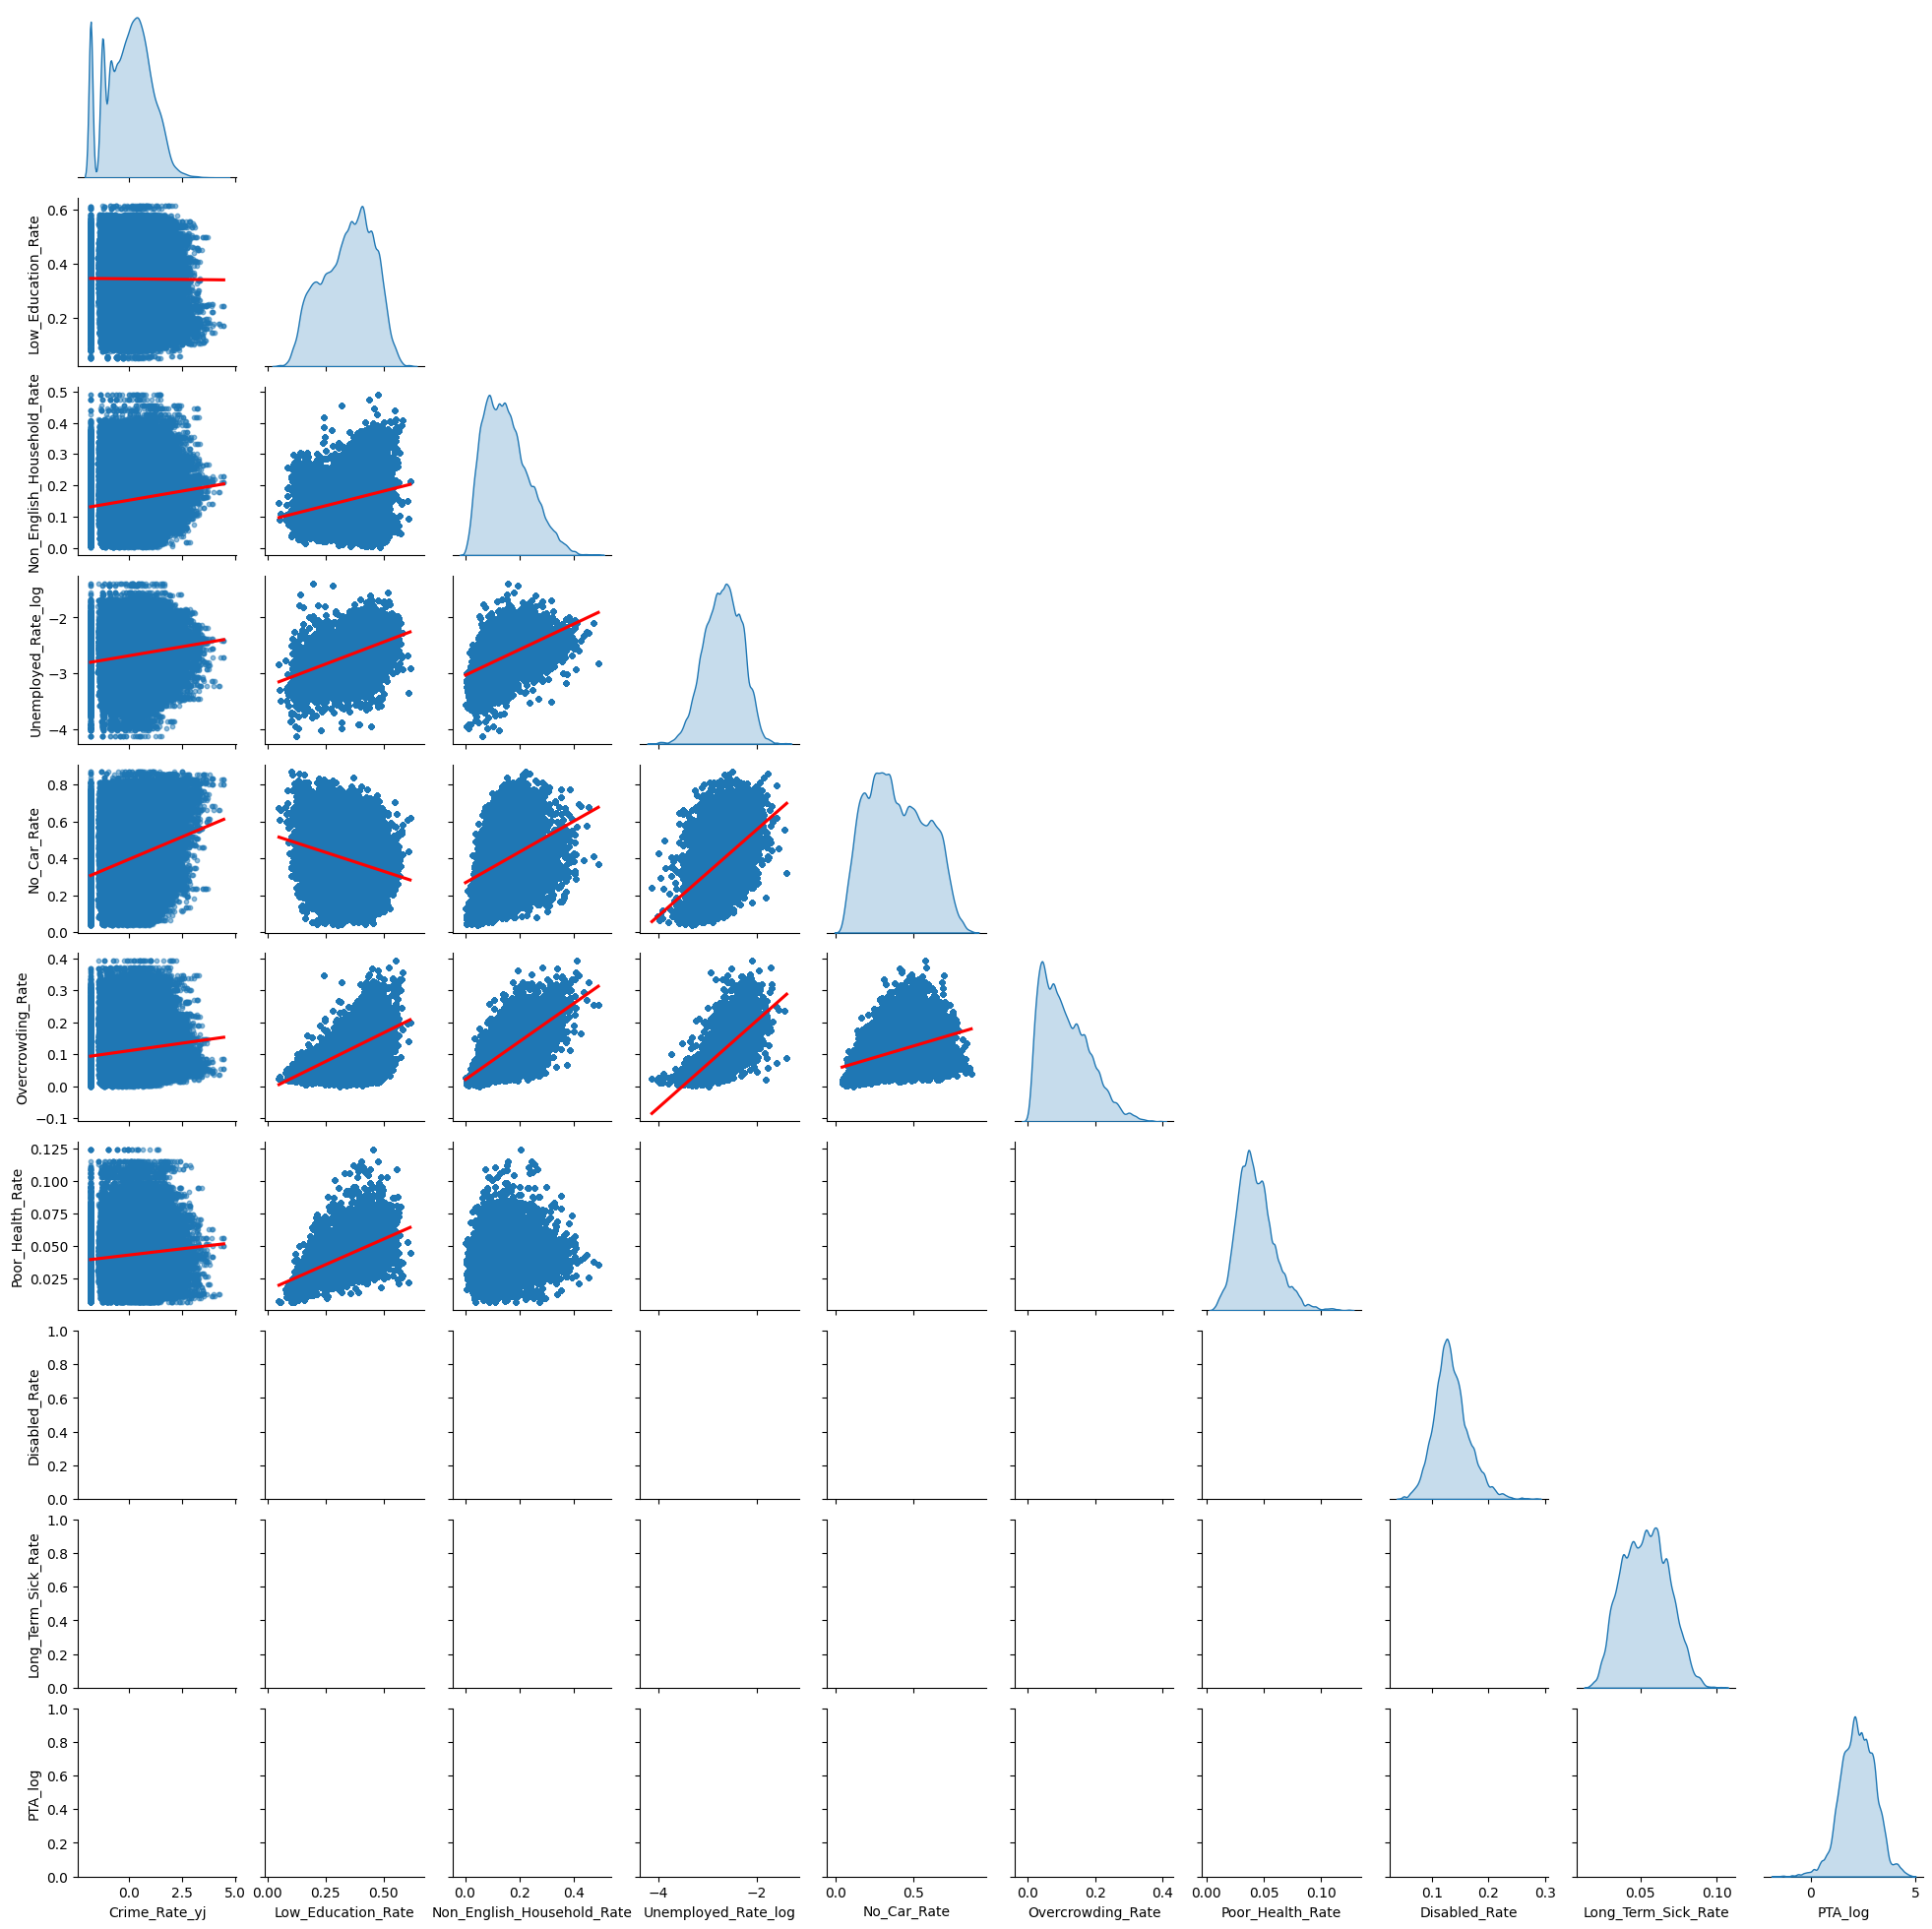

In [25]:
sns.pairplot(
    df_all[cols_to_plot],
    diag_kind="kde", 
    kind="reg", # add reg line on the scatter plot
    corner=True,   # only show the lower triangle
    height=2, 
    plot_kws={"line_kws": {"color": "red"},
              "scatter_kws": {"s": 10, "alpha": 0.5}} 
)

plt.suptitle("Pairwise Relationships of Selected Variables", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

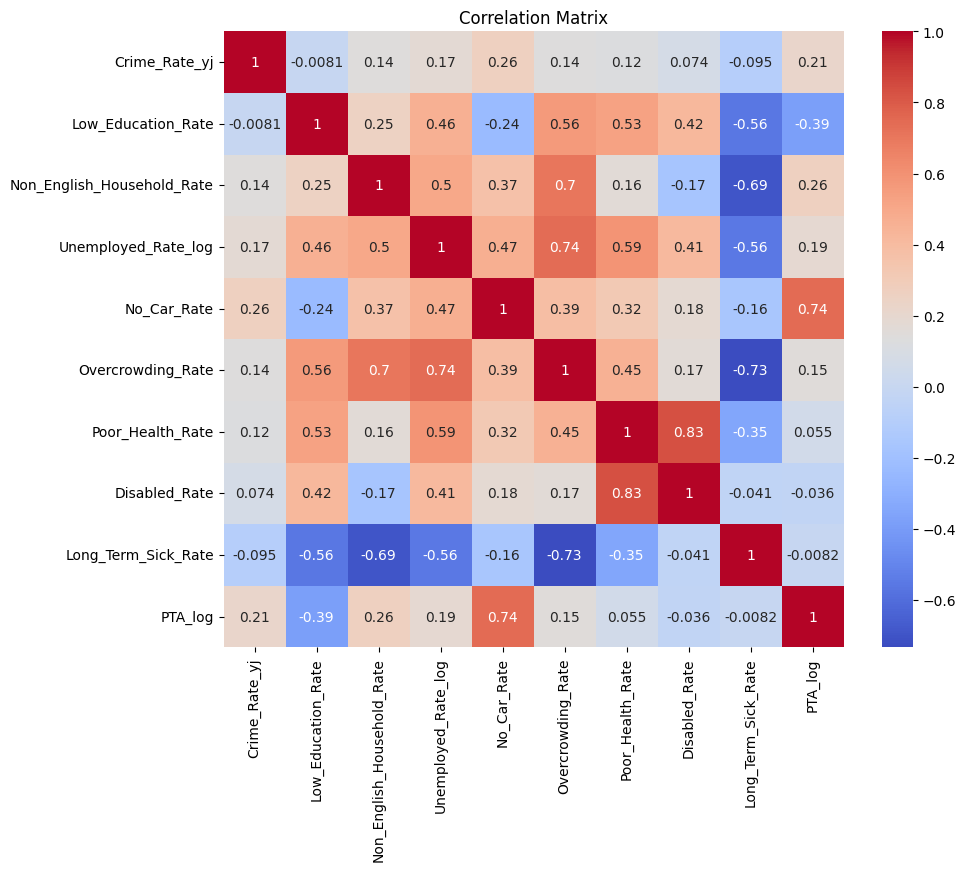

In [27]:
# calculate the correlation matrix
corr_matrix = df_all[cols_to_plot].corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

从相关矩阵可以看到，一些变量之间高度相关（如失业率与过度拥挤率、差健康率与残疾率等）。这说明变量之间存在多重共线性，会导致：
回归模型中系数不稳定；某些变量被重复放大；降低结果解释性。

因此使用 PCA 主成分分析 将多个相关变量压缩为少数几个互不相关的主成分，既保留了大部分信息，又减少冗余变量对模型的干扰。


### 4.1. PCA
如果原始变量高度偏态（特别是严重右偏），会让少数极端值主导方差解释所以针对之前严重偏态的变量（Crime_Rate和Public_Transport_Accessibility）采用做了对数变换后的数据。

In [28]:
# select variable columns for dimensionality reduction
cols_for_pca = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]

# standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_all[cols_for_pca])

# Initialize PCA
rand_st_int = 5525 
pca = PCA(random_state=rand_st_int)

X_pca = pca.fit_transform(X_scaled)

print(f"Number of PCs retained: {pca.n_components_}")
print(f"Explained variance ratio of each component: {pca.explained_variance_ratio_}")

# add the principal component results to the original table
for i in range(pca.n_components_):
    df_all[f"PCA_{i+1}"] = X_pca[:, i]

Number of PCs retained: 9
Explained variance ratio of each component: [0.44348997 0.23101478 0.18427584 0.03967997 0.03084459 0.02538293
 0.02185157 0.01269533 0.01076501]


In [29]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=cols_for_pca
)
display(loadings.round(2))

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Low_Education_Rate,0.31,-0.46,-0.14,-0.11,0.57,0.19,0.00,0.54,-0.12
Non_English_Household_Rate,0.34,0.25,-0.39,-0.23,-0.42,0.56,-0.31,0.14,0.10
Unemployed_Rate_log,0.43,0.03,0.07,0.71,-0.02,-0.21,-0.50,0.01,-0.10
No_Car_Rate,0.24,0.50,0.30,0.11,-0.14,-0.07,0.50,0.56,-0.04
Overcrowding_Rate,0.44,0.05,-0.21,0.22,0.25,0.23,0.52,-0.54,0.18
Poor_Health_Rate,0.36,-0.21,0.41,-0.30,-0.24,0.06,0.04,-0.27,-0.66
Disabled_Rate,0.23,-0.30,0.57,-0.14,-0.13,0.07,-0.10,-0.00,0.69
Long_Term_Sick_Rate,-0.39,0.03,0.37,0.38,0.13,0.73,-0.02,0.00,-0.14
PTA_log,0.10,0.58,0.24,-0.34,0.57,-0.02,-0.35,-0.17,0.01


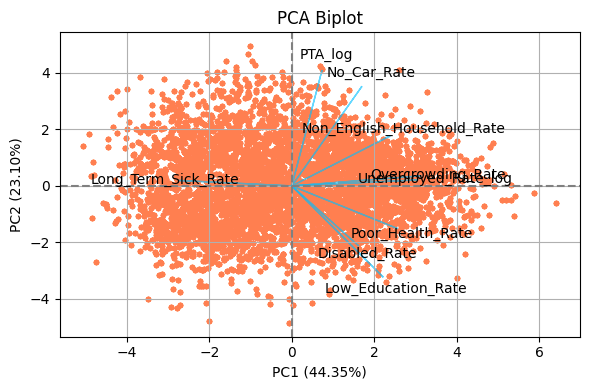

In [30]:
# extract the scores of the first two PCs and draw Biplot
# The figures drawn by 'bioinfokit' are not easy to modify, so use matplotlib to draw.
plt.figure(figsize=(6, 4))
xs = X_pca[:, 0]
ys = X_pca[:, 1]
plt.scatter(xs, ys, alpha=0.2, color="coral", s=8)

for i, var in enumerate(cols_for_pca):
    plt.arrow(0, 0,
              pca.components_[0, i]*7,
              pca.components_[1, i]*7,
              color='deepskyblue', alpha=0.6, head_width=0.02)
    plt.text(pca.components_[0, i]*8,
             pca.components_[1, i]*8,
             var, fontsize=10, ha="center", va="center")

plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0, color="gray", linestyle="--")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
plt.title("PCA Biplot")
plt.grid(True)
plt.tight_layout()
plt.show()

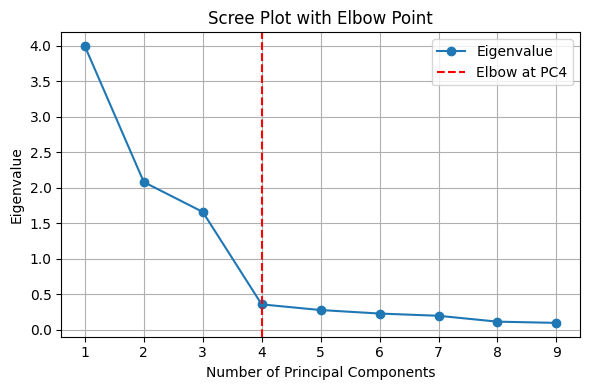

In [31]:
# use Scree plot to locate a point that occurs just before the Scree plot flattens out
eigenvalues = pca.explained_variance_
pcs = list(range(1, len(eigenvalues) + 1))

# use KneeLocator to find the elbow.
knee = KneeLocator(pcs, eigenvalues, curve='convex', direction='decreasing')

plt.figure(figsize=(6, 4))
plt.plot(pcs, eigenvalues, marker='o', label='Eigenvalue')
plt.axvline(x=knee.knee, color='red', linestyle='--', label=f'Elbow at PC{knee.knee}')
plt.title("Scree Plot with Elbow Point")
plt.xlabel("Number of Principal Components")
plt.ylabel("Eigenvalue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

肘部是碎石图（Scree Plot）中曲线从陡峭变为平缓的拐点，表示继续增加主成分时，新增的信息贡献边际递减。（肘部不是“第一次下降最大”，而是“后续开始平缓的拐点”）PC1 → PC2 的下降虽然大，但从 PC2 到 PC3、PC3 到 PC4 的下降仍然显著；换句话说，PC2 之后仍然有“较大的信息量”。所以 PC4 是这个“从陡到缓”的临界点，尽管只多解释了0.03959046，但是还是取到4，而且KneeLocator指示的也是4

In [32]:
variance_explained = pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1] + pca.explained_variance_ratio_[2] + pca.explained_variance_ratio_[3]
print(f"Proportion of variance explained by PC1 to PC4: {variance_explained:.2%}")

Proportion of variance explained by PC1 to PC4: 89.85%


为了解决变量之间存在的多重共线性问题，并提取背后潜在的社会经济结构特征，我们对 9 个标准化后的变量进行了主成分分析（PCA）。这些变量包括教育、语言、失业、交通、住房、健康等方面的比率型指标。

主成分分析结果显示：
根据 Scree Plot 的肘部法则，最优保留的主成分个数为前 4 个主成分累计解释了 89.86% 的总方差，其中 PC1 和 PC2 分别解释了 44.5% 和 23.1%，具备较强的代表性。
- PC1（Socioeconomic_Disadvantage）：这个维度强烈关联于“社会经济弱势群体聚集区域”。低教育、失业、高密度居住、健康状况差、交通条件差的地区，得分更高。
- PC2（Urban_Connectivity）：这个维度主要反映“交通可达性”。得分高的地区交通条件好，教育水平更高、车辆拥有率也更高。
- PC3（Language_Isolation）：Non_English_Household_Rate 为主要正向贡献，其余变量权重小。高分意味着非英语家庭集中，可能暗示较强的族群聚居特征。
- PC4（健康状况）：主要由 Poor_Health_Rate 和 Long_Term_Sick_Rate 贡献。高分意味着健康状况差，可能与社会经济劣势相关。

通过 PCA 降维，我们在保留主要信息的基础上有效降低了变量维度，为后续的聚类分析和回归建模提供了更加稳健的输入变量。

### 4.2. 初步线性回归

#### 检查假设

> A. Linearity
> 
> B. Homoscedasticity
> 
> C. Normality of residuals
> 
> D. Independence of errors
> 
> E. Multicollinearity (PCA已经消除)


<Figure size 600x400 with 0 Axes>

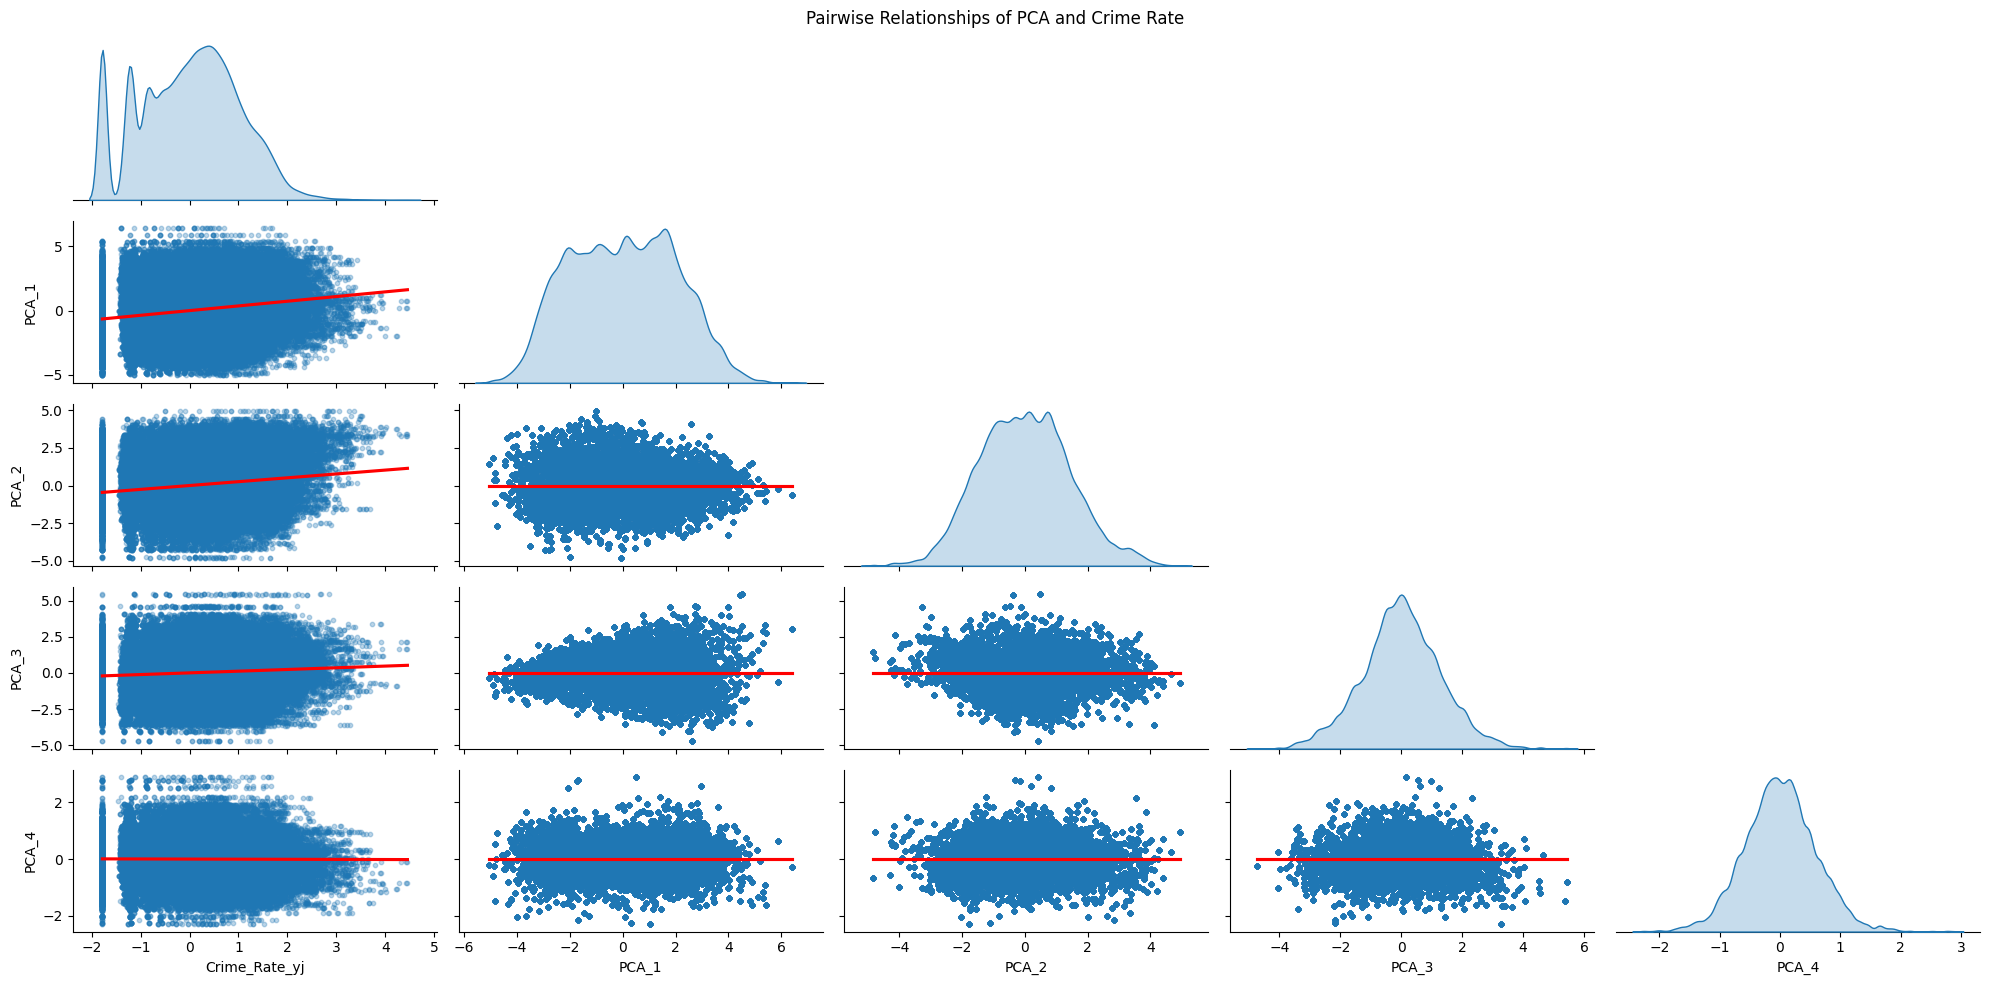

In [33]:
# A. Linearity
plt.figure(figsize=(6, 4))

sns.pairplot(
    df_all[["Crime_Rate_yj", "PCA_1", "PCA_2", "PCA_3", "PCA_4"]],
    diag_kind="kde",
    kind="reg",
    corner=True,
    height=2, 
    aspect=2, #the picture is compressed here for typesetting
    plot_kws={"line_kws": {"color": "red"}, 
              "scatter_kws": {"alpha": 0.3, "s": 10}}
)

plt.suptitle("Pairwise Relationships of PCA and Crime Rate", fontsize=12)
plt.tight_layout()
plt.show()


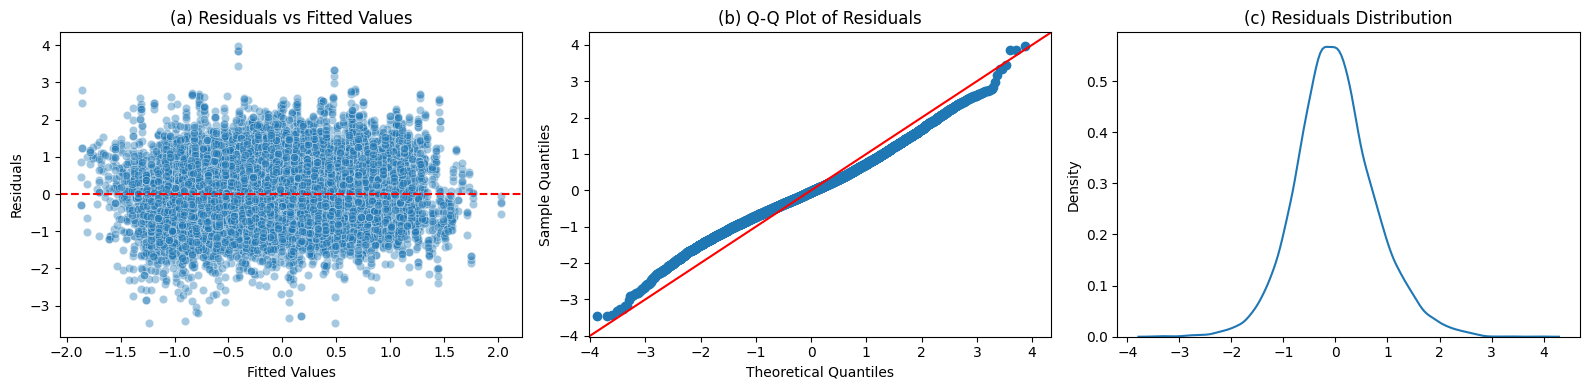

Durbin-Watson statistic: 0.6487436928814841


In [87]:
# fit the model
X = df_all[["PCA_1", "PCA_2", "PCA_3", "PCA_4"]]
X = sm.add_constant(X)
y = df_all["Crime_Rate_yj"]

model = sm.OLS(y, X).fit()


fig, axs = plt.subplots(1, 3, figsize=(16, 4))

# B. Homoscedasticity
# left：Residuals vs Fitted
fitted_vals = model.fittedvalues
residuals = model.resid
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.4, ax=axs[0])
axs[0].axhline(0, color='red', linestyle='--')
axs[0].set_xlabel("Fitted Values")
axs[0].set_ylabel("Residuals")
axs[0].set_title("(a) Residuals vs Fitted Values")

# C. Normality of residuals
# middle：Q-Q plot
sm.qqplot(residuals, line='45', ax=axs[1])
axs[1].set_title("(b) Q-Q Plot of Residuals")

# right：KDE plot
sns.kdeplot(residuals, ax=axs[2])
axs[2].set_title("(c) Residuals Distribution")

plt.tight_layout()
plt.show()


# D. Independence of errors
dw_stat = durbin_watson(model.resid) 
print("Durbin-Watson statistic:", dw_stat)


**A. Linearity**:使用 sns.pairplot() 查看自变量与因变量之间的散点分布与拟合线。图n结果显示大多数主成分与犯罪率呈现出大致线性趋势, 基本满足.
**B. Homoscedasticity**:图n-a,Residuals vs Fitted Plot 展示为云状分布，未呈现漏斗状或扩张趋势。基本满足.
C. Normality of residuals：使用QQ n-b 和KDE n-c 检查残差的正态性。残差接近正态，但在尾部略有偏离。基本满足.
D. Independence of errors：查看 Durbin-Watson 的结果。显著低于 2,可能存在 残差之间的正自相关.已经对变量做了大量前处理，包括 PCA 和变换 —— 所以结构性自相关很可能来自数据本身的时间或空间结构（比如 LSOA 固定特征或年份因素）。考虑引入固定效应（Fixed Effects）使用 Panel Regression
E. Multicollinearity: PCA已经消除

In [77]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Crime_Rate_yj   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     3181.
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        18:29:37   Log-Likelihood:                -21560.
No. Observations:               18612   AIC:                         4.313e+04
Df Residuals:                   18607   BIC:                         4.317e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.249e-15      0.006   3.98e-13      1.0

从回归结果可以看出R-squared = 0.406，模型可以解释大约 40.6% 的犯罪率变异。但是解释性没有那么好，

### 4.3. Clustering
在引入固定效应之前通过clustering看一下是否在每年、的不同区域有差异。因为crimerate numeric，所以接下来使用 K-means 聚类算法对数据进行聚类。

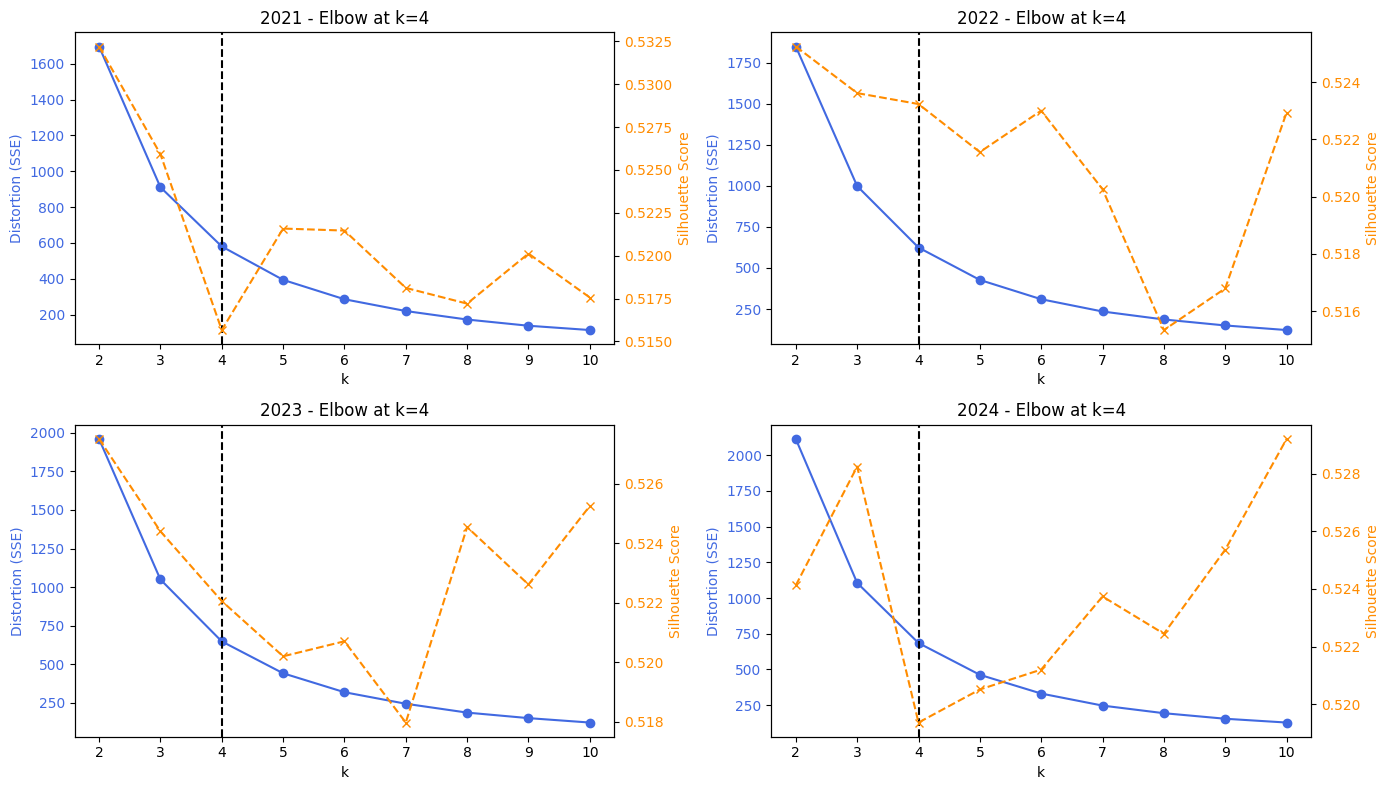

In [117]:
years = ['2021', '2022', '2023', '2024']
k_range = range(2, 11)
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for i, year in enumerate(years):
    df_year = df_all[df_all['Year'] == year]
    X = df_year[['Crime_Rate_yj']]

    sse = []
    silhouette = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=5525, n_init=10)
        labels = kmeans.fit_predict(X)
        sse.append(kmeans.inertia_)
        silhouette.append(silhouette_score(X, labels))

    # fine elbow point
    kl = KneeLocator(k_range, sse, curve='convex', direction='decreasing')
    elbow_k = kl.elbow
    
    row, col = divmod(i, 2)
    ax = axes[row, col]
    ax2 = ax.twinx()
    
    # elbow plot
    ax.plot(k_range, sse, marker='o', color='royalblue')
    ax.axvline(elbow_k, linestyle='--', color='black')
    ax.set_title(f"{year} - Elbow at k={elbow_k}")
    ax.set_xlabel("k")
    ax.set_ylabel("Distortion (SSE)", color='royalblue')
    ax.tick_params(axis='y', labelcolor='royalblue')

    # silhouette plot
    ax2.plot(k_range, silhouette, marker='x', color='darkorange', linestyle='--')
    ax2.set_ylabel("Silhouette Score", color='darkorange')
    ax2.tick_params(axis='y', labelcolor='darkorange')

plt.tight_layout()
plt.show()

虽然肘部法在四个年份均推荐使用 k=4，但 Silhouette 得分在 2021 和 2024 表现较差，说明这些年份的类内一致性或类间分离度不够理想，暗示各时间点的聚类结构存在差异。这表明犯罪率的空间分布在不同年份并不完全一致，存在时变的地理结构解释了为社么仅使用横截面方法可能无法捕捉时间变化带来的模式演变。 但是为了方便对比在clustering结果的可视化中中还是使用了k=4

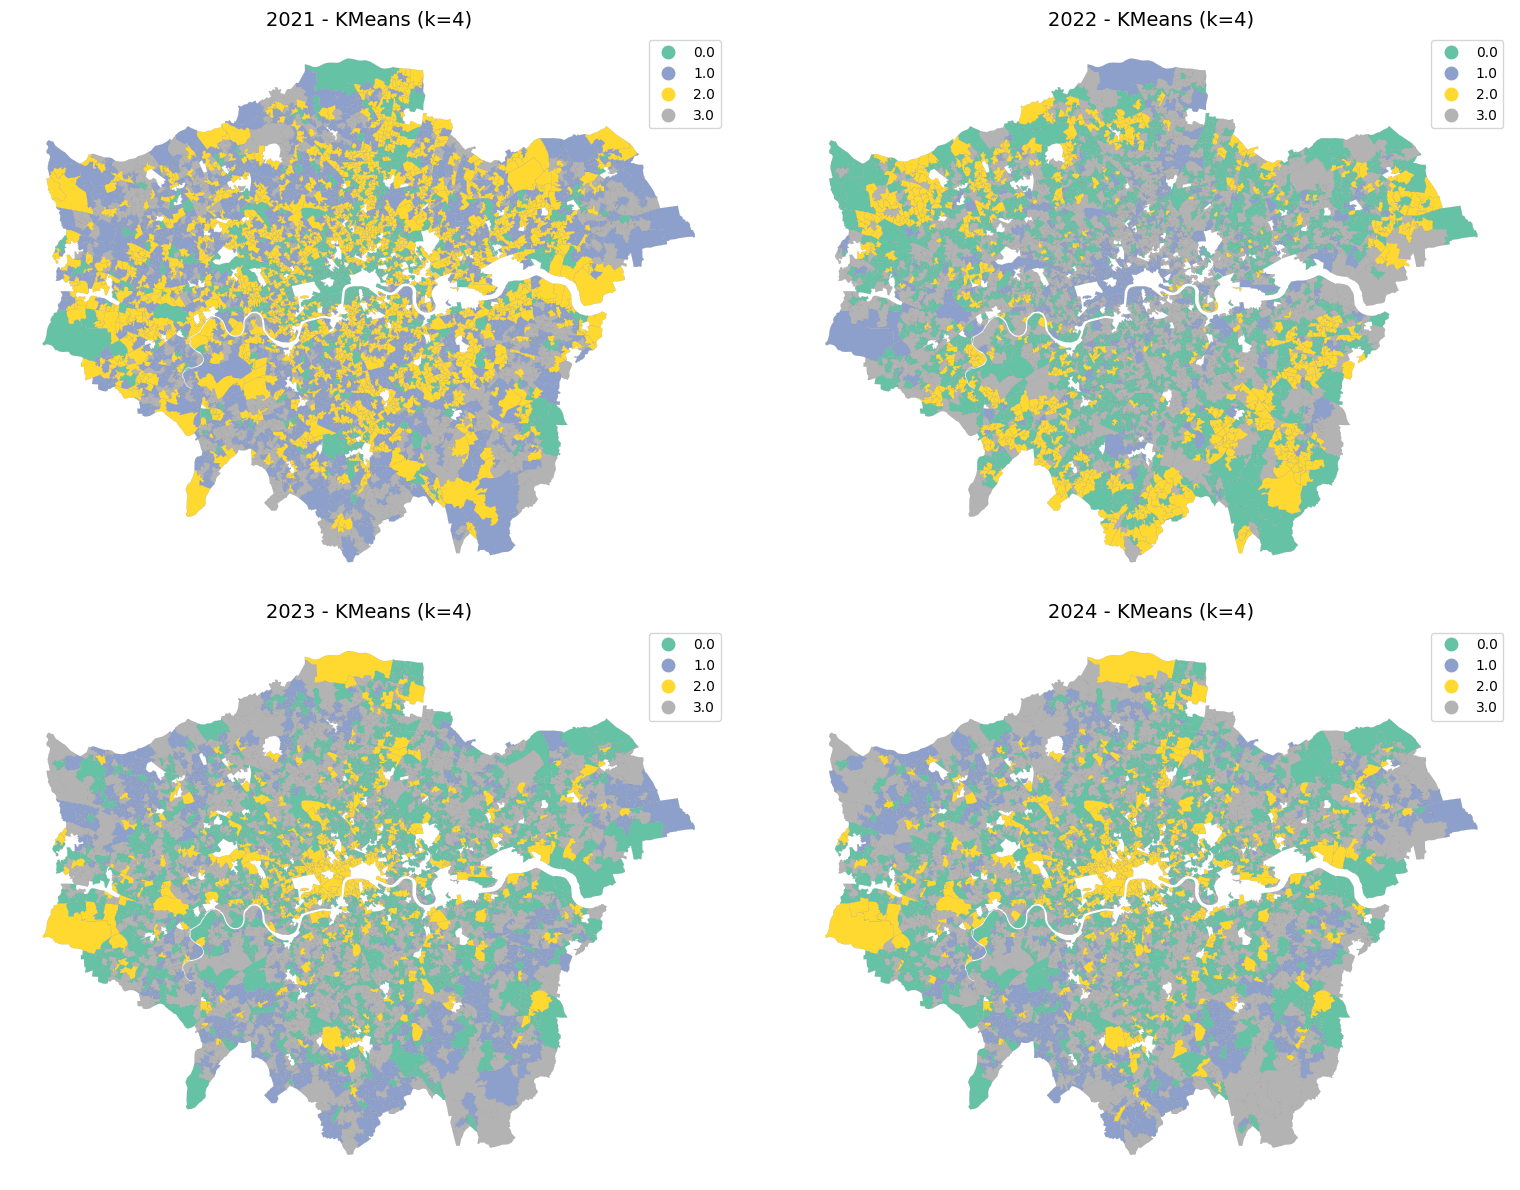

In [122]:
# 保证 geodataframe 有 LSOA_Code 字段
gdf_c_plot = gdf.copy()
gdf_c_plot = gdf_c_plot.rename(columns={"LSOA11CD": "LSOA_Code"})

# 设置年份和子图
years = ["2021", "2022", "2023", "2024"]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, year in enumerate(years):
    df_year = df_all[df_all["Year"] == year].copy()
    X = df_year[["Crime_Rate_yj"]]
    lsoa_codes = df_year["LSOA_Code"].values

    # 聚类
    kmeans = KMeans(n_clusters=4, random_state=5525, n_init=10)
    labels = kmeans.fit_predict(X)

    # 合并空间数据
    df_clustered = pd.DataFrame({"LSOA_Code": lsoa_codes, "cluster": labels})
    gdf_plot = gdf_c_plot.merge(df_clustered, on="LSOA_Code", how="left")

    # 画图
    row, col = divmod(i, 2)
    ax = axes[row, col]
    gdf_plot.plot(
        column="cluster",
        categorical=True,
        legend=True,
        cmap="Set2",
        linewidth=0.1,
        edgecolor="grey",
        ax=ax
    )
    ax.set_title(f"{year} - KMeans (k=4)", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

从聚类地图结果可以看出，LSOA 的空间分布格局呈现出一定的变化趋势尤其是中部和外围的聚类颜色发生了一些转换，提示某些区域的犯罪率聚类类别可能在不同年份发生了变化。这正是使用 固定效应 Panel Regression 的动因。

In [46]:
cols_to = [
    "Low_Education_Rate",
    "Non_English_Household_Rate",
    "Unemployed_Rate_log",
    "No_Car_Rate",
    "Overcrowding_Rate",
    "Poor_Health_Rate",
    "Disabled_Rate",
    "Long_Term_Sick_Rate",
    "PTA_log"
]

# 确保 Year 是整数（或也可以 pd.to_datetime）
df_panel = df_all.copy()
df_panel["Year"] = df_panel["Year"].astype(int)

df_panel["Panel_ID"] = df_panel["LSOA_Code"] + "_" + df_panel["Major_Category"]

# 设置面板索引（注意顺序：个体在前，时间在后）
# 设置为 2 层 MultiIndex：Panel_ID × Year
df_panel = df_panel.set_index(["Panel_ID", "Year"])


from linearmodels.panel import PanelOLS

# 自变量（不要含有时间不变又和固定效应冲突的变量）
exog_vars = cols_to
X = df_panel[exog_vars]
y = df_panel["Crime_Rate_yj"]

# 模型设定：实体固定效应（LSOA+CrimeType 组合），不加时间效应
model = PanelOLS(y, X, entity_effects=True)
results = model.fit()

print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:          Crime_Rate_yj   R-squared:                        0.0000
Estimator:                   PanelOLS   R-squared (Between):             -0.1941
No. Observations:              183572   R-squared (Within):               0.0000
Date:                Sun, Apr 20 2025   R-squared (Overall):             -0.1620
Time:                        00:26:54   Log-likelihood                -5.317e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.0000
Entities:                       46448   P-value                           1.0000
Avg Obs:                       3.9522   Distribution:                F(9,137115)
Min Obs:                       2.0000                                           
Max Obs:                       4.0000   F-statistic (robust):          3.368e-30
                            

### 4.4. Panel Regression
因为 panel regression 的核心价值 是：在控制每个个体（如每个 LSOA）的不变特征的前提下，分析 随时间变化的变量 如何影响随时间变化的结果。
因变量 Crime_Rate_yj：是每年变化的。
	•	所有自变量（PCA_1~4）：基于 2021年Census数据，对每个 LSOA 都是固定不变的。
	•	所以即使有四年的面板形式，解释变量在 panel 结构中是时间不变的。

在面板模型中，如果你加了 LSOA 固定效应（entity_effects=True），而自变量又不随时间变化，那么这些变量就会被完全吸收（absorbed），因为模型没法区分变量和单位自身的固定效应。



## 5. Results and discussion

[[ go back to the top ]](#Table-of-contents)

## 6. Conclusion

[[ go back to the top ]](#Table-of-contents)

## 7.References

[[ go back to the top ]](#Table-of-contents)

In [26]:
end_time = time.time()
total_time = end_time - start_time

mins, secs = divmod(total_time, 60)
print(f"🕒 Notebook running time: {int(mins)} h {int(mins)} m {secs:.2f} s")

🕒 Notebook running time: 0 h 0 m 41.28 s
